In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
def generate_xor_data(n):
  X = np.random.rand(n, 2) * 20 - 10
  X = np.where(X >= 0, X + 0.3, X - 0.3) # data on tensorflow playground was always away from the boundary.
  y = np.logical_xor(X[:, 0] > 0 , X[:, 1] > 0).astype(int)
  return torch.from_numpy(X).float(), torch.from_numpy(y).float()

# 200 train (including validation) + 200 test data.
X_train, y_train = generate_xor_data(160)
X_val, y_val = generate_xor_data(40)
X_test, y_test = generate_xor_data(200)

In [11]:
def plot_decision_boundary(model, X, y, title):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
  grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
  Z = model(grid).detach().numpy().reshape(xx.shape)
  plt.contourf(xx, yy, Z, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
  plt.title(title)
  plt.show()

class MLP(nn.Module):
  def __init__(self, l1=0, l2=0):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(2, 10)
    self.fc2 = nn.Linear(10, 10)
    self.fc3 = nn.Linear(10, 1)
    self.l1 = l1
    self.l2 = l2

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

  def regularization_loss(self):
    l1_loss = self.l1 * (torch.norm(self.fc1.weight, 1) + torch.norm(self.fc2.weight, 1) + torch.norm(self.fc3.weight, 1))
    l2_loss = self.l2 * (torch.norm(self.fc1.weight, 2) + torch.norm(self.fc2.weight, 2) + torch.norm(self.fc3.weight, 2))
    return l1_loss + l2_loss

def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()

  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train).squeeze()
    loss = criterion(output, y_train) + model.regularization_loss()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      model.eval()
      val_output = model(X_val).squeeze()
      val_loss = criterion(val_output, y_val)
      print(f'Epoch {epoch}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Loss: 0.7094718217849731, Val Loss: 0.6769928336143494
Epoch 10, Loss: 0.43558961153030396, Val Loss: 0.4854387640953064
Epoch 20, Loss: 0.24401259422302246, Val Loss: 0.2933815121650696
Epoch 30, Loss: 0.10366521775722504, Val Loss: 0.15282869338989258
Epoch 40, Loss: 0.04091691970825195, Val Loss: 0.08499959856271744


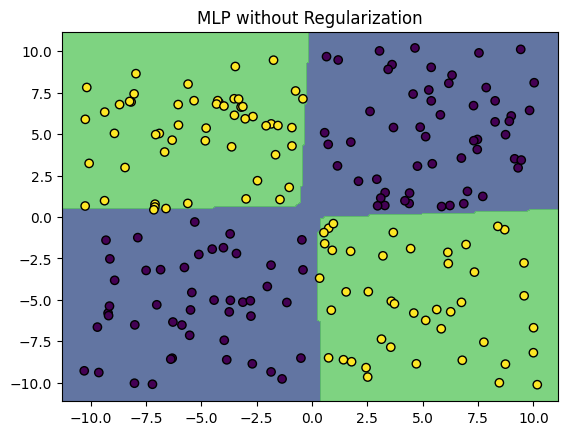

In [12]:
# MLP without Regularization
model_mlp = MLP()
train_model(model_mlp, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_mlp(x).squeeze() > 0.5, X_test, y_test, "MLP without Regularization")

Epoch 0, Loss: 0.8953744769096375, Val Loss: 0.6236260533332825
Epoch 10, Loss: 0.5923717021942139, Val Loss: 0.4239874482154846
Epoch 20, Loss: 0.4095534086227417, Val Loss: 0.21324479579925537
Epoch 30, Loss: 0.33204901218414307, Val Loss: 0.11699084937572479
Epoch 40, Loss: 0.3056090772151947, Val Loss: 0.08792686462402344


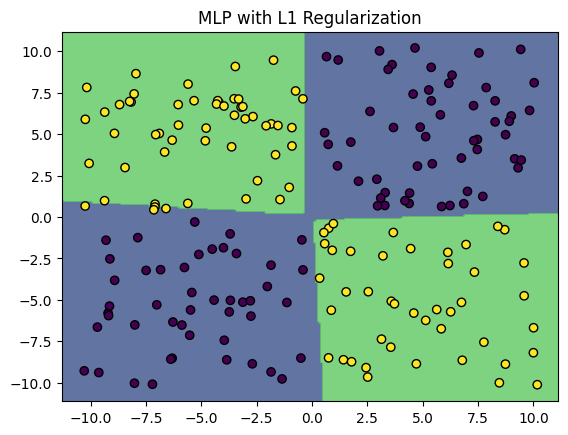

In [13]:
# MLP with L1 Regularization
best_l1_penalty = 0.01  # Adjust based on experimentation
model_l1 = MLP(l1=best_l1_penalty)
train_model(model_l1, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_l1(x).squeeze() > 0.5, X_test, y_test, "MLP with L1 Regularization")

Epoch 0, Loss: 0.7304038405418396, Val Loss: 0.6562417149543762
Epoch 10, Loss: 0.4558992385864258, Val Loss: 0.4086180329322815
Epoch 20, Loss: 0.23541168868541718, Val Loss: 0.19602148234844208
Epoch 30, Loss: 0.13321718573570251, Val Loss: 0.10500939935445786
Epoch 40, Loss: 0.10198947042226791, Val Loss: 0.0732378289103508


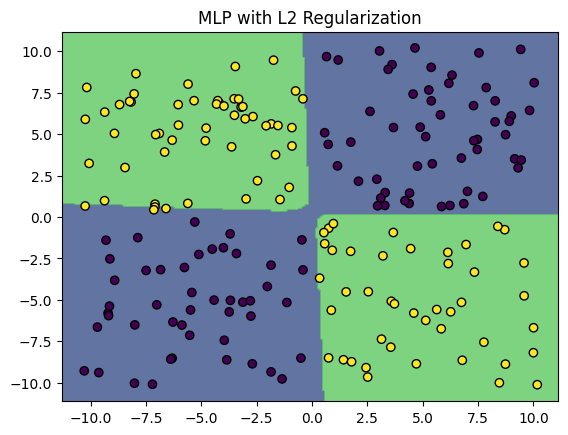

In [14]:
# MLP with L2 Regularization
best_l2_penalty = 0.01  # Adjust based on experimentation
model_l2 = MLP(l2=best_l2_penalty)
train_model(model_l2, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_l2(x).squeeze() > 0.5, X_test, y_test, "MLP with L2 Regularization")

Epoch 0, Loss: 1.8519006967544556
Epoch 50, Loss: 0.028584744781255722
Epoch 100, Loss: 0.02398339845240116
Epoch 150, Loss: 0.02120719663798809


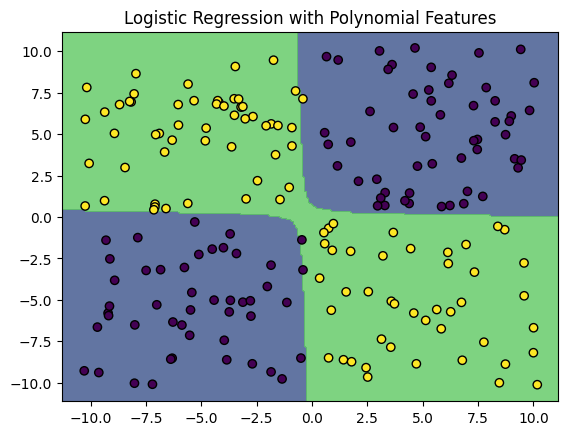

In [15]:
# Logistic Regression with Polynomial Features (without sklearn)
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def polynomial_features(X, degree=2):
    poly_features = [X]  # Start with original features

    for d in range(2, degree + 1):
        for i in range(d + 1):
            feature = (X[:, 0]**(d - i)) * (X[:, 1]**i)
            poly_features.append(feature.view(-1, 1))  # Reshape to [240, 1]

    return torch.cat(poly_features, dim=1)  # Concatenate along the second dimension

X_poly_train = polynomial_features(X_train, degree=2)
X_poly_test = polynomial_features(X_test, degree=2)

log_reg = LogisticRegressionModel(X_poly_train.shape[1])
optimizer = optim.SGD(log_reg.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Training Logistic Regression
for epoch in range(200):
    log_reg.train()
    optimizer.zero_grad()
    output = log_reg(X_poly_train).squeeze()
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Plot decision boundary for Logistic Regression with polynomial features
plot_decision_boundary(lambda x: log_reg(polynomial_features(x)).squeeze() > 0.5, X_test, y_test, "Logistic Regression with Polynomial Features")